In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import bisect
import matplotlib.pyplot as plt
import sys
dir_string = 'C:/Users/rannu/OneDrive - NTNU/Desktop/VsPython/'+\
                'Spain/NMfDS/Assignments/'
sys.path.append(dir_string + 'Ass4')
sys.path.append(dir_string + 'Ass6')
sys.path.append(dir_string + 'Ass7')
sys.path.append(dir_string + 'Ass8')
sys.path.append(dir_string + 'Ass9')
from RTBP_definitions import r1, r2, OMEGA, ODE_R3BP, Jacobi_first_integral
from Lagrange_computations import compute_Lagrange_pt, compute_jacobi_const_Li
from custom_ODE_solver import ODE_solver
from PoincareR3BP import poincare_map_solve_ivp_R3BP
from variational_equation_RTBP import variational_eq
from crossings_RTBP import crossings_R3BP_by_mu

In [3]:

def bisection_old(f, start, end, tol, N):
    """
    Input: function f, interval [start, end], tolerance tol, 
    max. number of iterations N

    Output: approximate solution mid
    """
    # Check if f(start) and f(end) have opposite signs
    if f(start)*f(end) >= 0:
        print("\nBisection method fails.")
        print("f(start) = ", f(start))
        print("f(end) = ", f(end))
        return None
    # Iterate until max. number of iterations is reached
    for i in range(N):
        # Compute midpoint
        mid = (start+end)/2
        # Check if f(mid) is zero
        if f(mid) == 0:
            break
        # Check if f(start) and f(mid) have opposite signs
        if f(start)*f(mid) < 0:
            end = mid
        # Otherwise, f(end) and f(mid) have opposite signs
        else:
            start = mid
        # Check if the interval is small enough
        if (end-start)/2 < tol:
            break
        if i == N-1:
            print("\nWarning: maximum number of iterations reached.")
    return mid

In [4]:
# Test scipy.optimize.bisect
def f(x):
    return x**2 - 2
print("Scipy bisection: ", bisect(f, 1, 2, xtol=1e-16, maxiter=200))
print("Exact solution:  ", np.sqrt(2))
print("Error:           ", np.abs(bisect(f, 1, 2, xtol=1e-10, maxiter=100)\
                                  -np.sqrt(2)))

Scipy bisection:  1.414213562373095
Exact solution:   1.4142135623730951
Error:            4.705502654189786e-11


In [5]:
# HINT: it should work with
# mu=0.1, cmin=2.1 cmax=3.189, xincC=1.d-3, xincini=1.d-5, xincx=1.d-3

In [6]:
mu = 0.1
print(compute_Lagrange_pt(mu, 3))
L3 = [compute_Lagrange_pt(mu, 3), 0, 0, 0]
L3.extend([1, 0, 0, 0, 
           0, 1, 0, 0, 
           0, 0, 1, 0, 
           0, 0, 0, 1])  # initial conditions and identity matrix
time_span = 0

# compute the Jacobian matrix of the RTBP at Li.
# The eigenvalues of this matrix are the frequencies of the periodic orbit

A = variational_eq(time_span, L3, mu, 1)[4:20].reshape(4,4)
print('det(A) = \n', A)
eigenvalues, eigenvectors = np.linalg.eig(A)
lambda_pos = eigenvalues[3].real
lambda_neg = eigenvalues[2].real
eigvec_pos = eigenvectors[:,3]
eigvec_neg = eigenvectors[:,2]
print('\neigenvalues = \n', lambda_pos, ",", lambda_neg)
print('\nTheir respective normalized eigenvectors = \n', -eigvec_pos.real, \
      ",\n", eigvec_neg.real)
# Only the real part of the eigenvectors are needed

1.0416089085718845
det(A) = 
 [[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 3.18338396  0.          0.          2.        ]
 [ 0.         -0.09169198 -2.          0.        ]]

eigenvalues = 
 0.5016383507584008 , -0.5016383507584007

Their respective normalized eigenvectors = 
 [ 0.28940578 -0.84569227  0.14517704 -0.42423167] ,
 [-0.28940578 -0.84569227  0.14517704  0.42423167]


In [7]:
# Assume C fixed. Implement a routine such that, given an initial x,
# sign of y’ and C, computes (as output) y’, such that the initial condition
# of the orbit will be (x,0,0,y’).
                      
# def Jacobi_first_integral(mu, x, y, vx, vy):
#     # Function to compute the Jacobi first integral
#     # This should be constant for a given value of mu
#     return 2*OMEGA(mu, x, y) - (vx**2 + vy**2)

def yderiv(mu, x, y, vx, sign_vy, C):
    # Function to compute the derivative of y for a given value of C
    return sign_vy*np.sqrt(2*OMEGA(mu, x, y) - C - vx**2)

C = Jacobi_first_integral(mu, L3[0], L3[1], L3[2], L3[3])

vy = yderiv(mu, L3[0], L3[1], L3[2], 1, C)

print('\nC = ', C)
print('\nvy = ', vy)


C =  3.1895781504493814

vy =  0.0


In [8]:
def F_old(x, vy):
    init_cond = [x, 0, 0, vy]
    # Find the crossing time of the unstable manifold with the Poincare section
    iregion = 1
    t0 = 0
    tmax = 0.15
    dt = 0.1
    t_span = np.arange(t0, tmax, dt)

    # Variables for tweaking the accuracy of the crossing time
    refinement = 20000
    refinement_fine = 300
    tol = 1e-14

    newInitial, TimeDuration,_ = \
        poincare_map_solve_ivp_R3BP(lambda t, X: ODE_R3BP(t, mu, X), 
                                    init_cond, 
                                    iregion, dt, t_span, mu, 
                                    init_search = refinement, 
                                    refinement = refinement_fine, 
                                    newton_tol = tol)

    tmax_plot = TimeDuration
    t_span_plot = np.arange(t0, tmax_plot, 0.01)

    # Solve ode_r3bp using the custom ODE solver,  RETURNS: the solution of the 
    # system of ODEs as a scipy.integrate.solve_ivp object
    sol = ODE_solver(lambda t, X: ODE_R3BP(t, mu, X), init_cond, tmax_plot, 
                    len(t_span_plot), tol=1e-12, method='DOP853', hamiltonian=0)

    # Extract the solution
    x = sol.y[0]
    y = sol.y[1]
    vx = sol.y[2]
    vy = sol.y[3]
    return x, y, vx, vy, t_span_plot, newInitial, TimeDuration

In [60]:
# Assume C fixed. Implement a routine such that given an initial x
# and the ’associated’ initial condition (x,0,0,y’), returns as
# output F(x)=x’ (at a given crossing).
def F(x, C):
    vy = yderiv(mu, x, 0, 0, -1, C)
    init_cond = [x, 0, 0, vy]

    iregion = 1
    t0 = 0
    tmax = 1
    dt = 0.3
    t_span = np.arange(t0, tmax, dt)

    # Variables for tweaking the accuracy of the crossing time
    refinement = 2000
    refinement_fine = 300
    tol = 1e-2

    newInitial, TimeDuration,_ = \
        poincare_map_solve_ivp_R3BP(lambda t, X: ODE_R3BP(t, mu, X), 
                                    init_cond, 
                                    iregion, dt, t_span, mu, 
                                    init_search = refinement, 
                                    refinement = refinement_fine, 
                                    init_tol=1e-5,
                                    newton_tol = tol)
    
    return newInitial[2] #x'

In [10]:
# Define a functiont that varies x such that you find x1 and x2 such that F(x,C)
# changes sign.

def F_rough_search(x0, x_inc, C):
    # Function to compute the x value where F(x,C) changes sign
    # x0 is the initial guess for the root
    # x_inc is the increment we add to x used to compute the derivative of F(x,C)
    # C is the Jacobi constant
    x1 = x0
    x2 = x0 + x_inc
    F1 = F(x1, C)
    F2 = F(x2, C)
    while F1*F2 > 0:
        x1 = x2
        x2 += x_inc
        F1 = F2
        F2 = F(x2, C)
    return x1, x2

In [38]:
# Now refine x, using scipy bisection, such that F(x)=0.
# (ie |F(x)|<1.d-12)

def F_refine_bisection(x1, x2, C):
    # Function to refine the root of F(x,C) using scipy bisection
    # x1 and x2 are the x values where F(x,C) changes sign
    # C is the Jacobi constant
    return bisect(lambda x: F(x, C), x1, x2, xtol=1e-3, maxiter=10)

In [39]:

# x1, x2:  2.213118049196732 2.214118049196732 
# C =  2.3200000000000958 i =  869

mu = 0.1
cmin = 2.1
cmax = 3.189
xincC = 1e-3 
xincx = 1e-3

# Find the first root of F(x,C) for C = cmin

x_0 = 2.213118049196732

print('x_0 = ', x_0)

C = 2.3200000000000958 + xincC*4
x1, x2 = F_rough_search(x_0, xincx, C)
print('x1 = ', x1, ', x2 = ', x2)



x_0 =  2.213118049196732
x1 =  2.214118049196732 , x2 =  2.215118049196732


In [40]:
# use bisect to refine the root
x_root = F_refine_bisection(x1, x2, C)

In [36]:
print('x_root = ', x_root)
# root - x1
print('root - x1 = ', x_root - x1)
# root - x2
print('root - x2 = ', x_root - x2)

x_root =  2.2146180491967318
root - x1 =  0.0004999999999997229
root - x2 =  -0.000500000000000167


[ 2.21461805e+00  1.48427048e-15  1.39854086e-15 -1.89366417e+00]


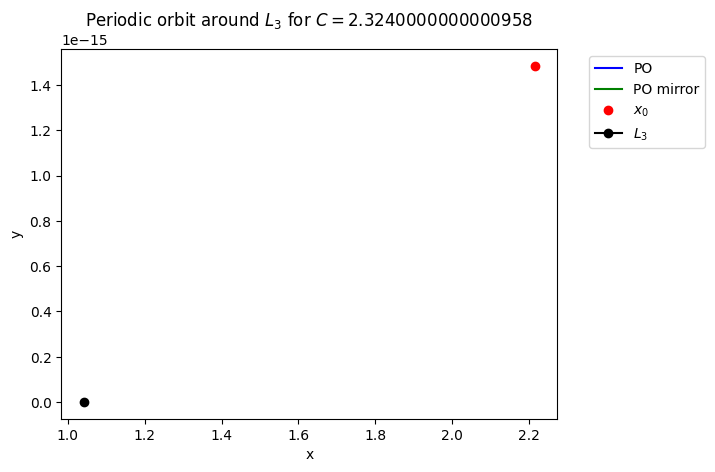

In [41]:
vy = yderiv(mu, x_root, 0, 0, -1, C)
x, y, vx, vy, t_span_plot, newInitial, TimeDuration = F_old(x_root, vy)


print(newInitial)
L3 = [compute_Lagrange_pt(mu, 3), 0, 0, 0]
x_L3 = L3[0]
# Plot the orbit
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, 'b')
ax.plot(x, -y, 'g')
ax.plot(newInitial[0], newInitial[1], 'ro')
ax.plot(x_L3, 0, color = 'black', marker = 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Periodic orbit around $L_3$ for $C = {C}$')
# make a legend
legend = [r'PO', r'PO mirror', r'$x_0$', r'$L_3$']
#plot the legend outside of the plot
ax.legend(legend, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [25]:
loaded_arr_x_vals_first_800 = np.load('x_vals_first_800.npy')

In [26]:
print(loaded_arr_x_vals_first_800)

[1.04604578 1.07365223 1.08254774 ... 0.         0.         0.        ]


In [27]:
print(loaded_arr_x_vals_first_800[800])

1.713352424196788


In [62]:
from tqdm import tqdm
def characteristic_curve_last_200():
    mu = 0.1
    cmin = 2.1
    cmax = 3.189
    xincC = 1e-3
    xincx = 1e-3-1e-5 
    C_vals = np.arange(cmax, cmin, -xincC)
    x_vals = np.zeros(len(C_vals))
    print('C_vals = ', C_vals, 'number of C values = ', len(C_vals))
    # first initial search for the root

    x_0 = loaded_arr_x_vals_first_800[800]
    
    x1, x2 = F_rough_search(x_0, xincx, C_vals[801])
    x_root = F_refine_bisection(x1, x2, C_vals[801])
    x_vals[801] = x_root
    x_fails = []
    print("initial search done")
    # now loop over the rest of the C values
    for i in tqdm(range(802, len(C_vals))):
        x1, x2 = F_rough_search(x_vals[i-1], xincx, C_vals[i])
        print('x1, x2: ', x1, x2, 'C = ', C_vals[i], 'i = ', i)
        if x1 - x_vals[i-1] > 0.1:
            x_vals[i] = x_vals[i-1]
            x_fails.append(i)
        else:
            x_root = F_refine_bisection(x1, x2, C_vals[i])
            print('x_root = ', x_root)
            x_vals[i] = x_root
        if i == 900:
            np.save('x_vals_last_800_to_900.npy', x_vals)
            np.save('C_vals_last_800_to_900.npy', C_vals)
        if i == 950:
            np.save('x_vals_last_800_to_950.npy', x_vals)
            np.save('C_vals_last_800_to_950.npy', C_vals)
        if i == 1000:
            np.save('x_vals_last_800_to_1000.npy', x_vals)
            np.save('C_vals_last_800_to_1000.npy', C_vals)
        if i == 1050:
            np.save('x_vals_last_800_to_1050.npy', x_vals)
            np.save('C_vals_last_800_to_1050.npy', C_vals)

    return C_vals, x_vals, x_fails
# 12
C_vals_end, x_vals_end, x_fails = characteristic_curve_last_200()

np.save('x_vals_last_200.npy', x_vals_end)
np.save('C_vals_last_200.npy', C_vals_end)

C_vals =  [3.189 3.188 3.187 ... 2.103 2.102 2.101] number of C values =  1089
initial search done


  0%|          | 0/287 [00:00<?, ?it/s]

x1, x2:  1.7168174241967882 1.7178074241967882 C =  2.3870000000000884 i =  802
x_root = 

  0%|          | 1/287 [00:00<01:29,  3.21it/s]

 1.717312424196788


  1%|          | 2/287 [00:01<04:53,  1.03s/it]

x1, x2:  1.7331524241967888 1.7341424241967889 C =  2.3860000000000885 i =  803
x_root =  1.7336474241967887
x1, x2:  1.7336474241967887 1.7346374241967888 C =  2.3850000000000886 i =  804


  1%|          | 3/287 [00:02<03:25,  1.38it/s]

x_root =  1.7341424241967887
x1, x2:  1.7341424241967887 1.7351324241967887 C =  2.3840000000000887 i =  805


  1%|▏         | 4/287 [00:02<02:40,  1.76it/s]

x_root =  1.7346374241967886
x1, x2:  1.7346374241967886 1.7356274241967886 C =  2.383000000000089 i =  806


  2%|▏         | 5/287 [00:02<02:14,  2.10it/s]

x_root =  1.7351324241967885
x1, x2:  1.7351324241967885 1.7361224241967885 C =  2.382000000000089 i =  807


  2%|▏         | 6/287 [00:03<01:58,  2.37it/s]

x_root =  1.7356274241967884
x1, x2:  1.7356274241967884 1.7366174241967884 C =  2.381000000000089 i =  808


  2%|▏         | 7/287 [00:03<01:50,  2.53it/s]

x_root =  1.7361224241967883
x1, x2:  1.7361224241967883 1.7371124241967884 C =  2.380000000000089 i =  809


  3%|▎         | 8/287 [00:03<01:44,  2.66it/s]

x_root =  1.7366174241967882
x1, x2:  1.7366174241967882 1.7376074241967883 C =  2.3790000000000893 i =  810


  3%|▎         | 9/287 [00:04<01:40,  2.78it/s]

x_root =  1.7371124241967881
x1, x2:  1.7371124241967881 1.7381024241967882 C =  2.3780000000000894 i =  811


  3%|▎         | 10/287 [00:04<01:37,  2.84it/s]

x_root =  1.737607424196788
x1, x2:  1.737607424196788 1.738597424196788 C =  2.3770000000000895 i =  812


  4%|▍         | 11/287 [00:04<01:34,  2.91it/s]

x_root =  1.738102424196788


  4%|▍         | 12/287 [00:47<1:00:53, 13.28s/it]

x1, x2:  2.2291424241967595 2.2301324241967593 C =  2.3760000000000896 i =  813
x1, x2:  1.738102424196788 1.739092424196788 C =  2.3750000000000897 i =  814


  5%|▍         | 13/287 [00:48<42:44,  9.36s/it]  

x_root =  1.7385974241967879
x1, x2:  1.7385974241967879 1.739587424196788 C =  2.37400000000009 i =  815


  5%|▍         | 14/287 [00:48<30:11,  6.64s/it]

x_root =  1.7390924241967878
x1, x2:  1.7390924241967878 1.7400824241967878 C =  2.37300000000009 i =  816


  5%|▌         | 15/287 [00:48<21:28,  4.74s/it]

x_root =  1.7395874241967877
x1, x2:  1.7395874241967877 1.7405774241967877 C =  2.37200000000009 i =  817


  6%|▌         | 16/287 [00:49<15:24,  3.41s/it]

x_root =  1.7400824241967876
x1, x2:  1.7400824241967876 1.7410724241967876 C =  2.37100000000009 i =  818


  6%|▌         | 17/287 [00:49<11:13,  2.49s/it]

x_root =  1.7405774241967875
x1, x2:  1.7405774241967875 1.7415674241967876 C =  2.3700000000000903 i =  819


  6%|▋         | 18/287 [00:49<08:16,  1.85s/it]

x_root =  1.7410724241967874
x1, x2:  1.7410724241967874 1.7420624241967875 C =  2.3690000000000904 i =  820


  7%|▋         | 19/287 [00:50<06:15,  1.40s/it]

x_root =  1.7415674241967873
x1, x2:  1.7415674241967873 1.7425574241967874 C =  2.3680000000000905 i =  821


  7%|▋         | 20/287 [00:50<04:48,  1.08s/it]

x_root =  1.7420624241967873
x1, x2:  1.7420624241967873 1.7430524241967873 C =  2.3670000000000906 i =  822


  7%|▋         | 21/287 [00:50<03:48,  1.17it/s]

x_root =  1.7425574241967872
x1, x2:  1.7425574241967872 1.7435474241967872 C =  2.3660000000000907 i =  823


  8%|▊         | 22/287 [00:51<03:07,  1.42it/s]

x_root =  1.743052424196787
x1, x2:  1.743052424196787 1.7440424241967871 C =  2.365000000000091 i =  824


  8%|▊         | 23/287 [00:51<02:37,  1.67it/s]

x_root =  1.743547424196787


  8%|▊         | 24/287 [01:22<42:57,  9.80s/it]

x1, x2:  2.2345874241967576 2.2355774241967574 C =  2.364000000000091 i =  825
x1, x2:  1.743547424196787 1.744537424196787 C =  2.363000000000091 i =  826


  9%|▊         | 25/287 [01:23<30:26,  6.97s/it]

x_root =  1.744042424196787
x1, x2:  1.744042424196787 1.745032424196787 C =  2.362000000000091 i =  827


  9%|▉         | 26/287 [01:23<21:40,  4.98s/it]

x_root =  1.7445374241967868
x1, x2:  1.7445374241967868 1.7455274241967869 C =  2.3610000000000912 i =  828


  9%|▉         | 27/287 [01:23<15:37,  3.60s/it]

x_root =  1.7450324241967867
x1, x2:  1.7450324241967867 1.7460224241967868 C =  2.3600000000000914 i =  829


 10%|▉         | 28/287 [01:24<11:17,  2.62s/it]

x_root =  1.7455274241967866
x1, x2:  1.7455274241967866 1.7465174241967867 C =  2.3590000000000915 i =  830


 10%|█         | 29/287 [01:24<08:17,  1.93s/it]

x_root =  1.7460224241967865
x1, x2:  1.7460224241967865 1.7470124241967866 C =  2.3580000000000916 i =  831


 10%|█         | 30/287 [01:24<06:12,  1.45s/it]

x_root =  1.7465174241967865
x1, x2:  1.7465174241967865 1.7475074241967865 C =  2.3570000000000917 i =  832


 11%|█         | 31/287 [01:25<04:45,  1.12s/it]

x_root =  1.7470124241967864
x1, x2:  1.7470124241967864 1.7480024241967864 C =  2.356000000000092 i =  833


 11%|█         | 32/287 [01:25<03:45,  1.13it/s]

x_root =  1.7475074241967863
x1, x2:  1.7475074241967863 1.7484974241967863 C =  2.355000000000092 i =  834


 11%|█▏        | 33/287 [01:25<03:03,  1.38it/s]

x_root =  1.7480024241967862
x1, x2:  1.7480024241967862 1.7489924241967862 C =  2.354000000000092 i =  835


 12%|█▏        | 34/287 [01:26<02:33,  1.65it/s]

x_root =  1.748497424196786


 12%|█▏        | 35/287 [01:57<41:13,  9.81s/it]

x1, x2:  2.223697424196758 2.224687424196758 C =  2.353000000000092 i =  836
x1, x2:  1.748497424196786 1.7494874241967862 C =  2.3520000000000922 i =  837


 13%|█▎        | 36/287 [01:57<29:11,  6.98s/it]

x_root =  1.748992424196786
x1, x2:  1.748992424196786 1.749982424196786 C =  2.3510000000000923 i =  838


 13%|█▎        | 37/287 [01:58<20:47,  4.99s/it]

x_root =  1.749487424196786
x1, x2:  1.749487424196786 1.750477424196786 C =  2.3500000000000925 i =  839


 13%|█▎        | 38/287 [01:58<14:56,  3.60s/it]

x_root =  1.7499824241967858
x1, x2:  1.7499824241967858 1.750972424196786 C =  2.3490000000000926 i =  840


 14%|█▎        | 39/287 [01:58<10:51,  2.63s/it]

x_root =  1.7504774241967858
x1, x2:  1.7504774241967858 1.7514674241967858 C =  2.3480000000000927 i =  841


 14%|█▍        | 40/287 [01:59<07:59,  1.94s/it]

x_root =  1.7509724241967857
x1, x2:  1.7509724241967857 1.7519624241967857 C =  2.347000000000093 i =  842


 14%|█▍        | 41/287 [01:59<06:01,  1.47s/it]

x_root =  1.7514674241967856
x1, x2:  1.7514674241967856 1.7524574241967856 C =  2.346000000000093 i =  843


 15%|█▍        | 42/287 [02:00<04:42,  1.15s/it]

x_root =  1.7519624241967855
x1, x2:  1.7519624241967855 1.7529524241967855 C =  2.345000000000093 i =  844


 15%|█▍        | 43/287 [02:00<03:40,  1.11it/s]

x_root =  1.7524574241967854
x1, x2:  1.7524574241967854 1.7534474241967855 C =  2.344000000000093 i =  845


 15%|█▌        | 44/287 [02:00<02:58,  1.36it/s]

x_root =  1.7529524241967853


 16%|█▌        | 45/287 [02:46<57:28, 14.25s/it]

x1, x2:  2.2271624241967567 2.2281524241967565 C =  2.3430000000000932 i =  846


 16%|█▌        | 46/287 [03:38<1:42:42, 25.57s/it]

x1, x2:  2.2241924241967572 2.225182424196757 C =  2.3420000000000933 i =  847


 16%|█▌        | 46/287 [27:42<2:25:09, 36.14s/it]


KeyboardInterrupt: 